Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE".

Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All). On JupyterLab, you may want to hit the "Validate" button as well.

Caution: do not mess with the notebook's metadata; do not change a pre-existing cell's type; do not copy pre-existing cells (add new ones with the + button instead). This will break autograding; you will get a 0; you are warned.

<table style="width: 100%; border: none;" cellspacing="0" cellpadding="0" border="0">
  <tr>
    <td><img src="https://www.planetegrandesecoles.com/wp-content/uploads/2021/07/Identite%CC%81-visuelle-Plane%CC%80te-BAC-8-600x398.png" style="float: left; width: 100%" />
</td>
    <td><a style="font-size: 3em; text-align: center; vertical-align: middle;" href="https://moodle.polytechnique.fr/course/view.php?id=19260">[CSC2S004EP - 2024] - Introduction to Machine Learning</a>
</td>
  </tr>
</table>

<a style="font-size: 3em;">Lab Session 11: Dimensionality Reduction with AutoEncoders</a>

J.B. Scoggins - Adrien Ehrhardt - Johannes Lutzeyer - Jesse Read

In [21]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.datasets.mnist as mnist
from tensorflow.keras.layers import Dense, Input, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras import Model

import keras  # used in tests

# Introduction

In this lab, you will get hands-on experience with Autoencoders. The goal is to find a suitable transformation of a high-dimensional space into a smaller feature space, i.e., a good low-dimensional *representation* for the data.

# Recall the original MNIST Dataset and PCA decomposition

We will reuse the MNIST digits dataset throughout this excercise. Recall that the original MNIST dataset provides $60{,}000$ 28x28 pixels (in grayscale) training images of hand-written digits 0-9. The images are labeled with integer values 0-9. The training set has become the _de facto_ image classification example due to its relative small size.

In this exercise, we are not interested in classifying images of digits, but transforming the 784d space into a smaller representation.  

As per earlier labs, we use the `keras.datasets` module to load the MNIST dataset, normalize it, and get to know how it is structured.

In [22]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0
x_train_reshaped = x_train.reshape(60000, 784)

The shape of `x_train`, `x_train_reshaped` and `y_train` correspond to what we expect:

In [23]:
print(x_train.shape)  # 28 by 28 pixels
print(x_train_reshaped.shape)  # flattened 28 by 28 = 784 "pixels"
print(y_train.shape)  # one column of labels {0, ..., 9}

(60000, 28, 28)
(60000, 784)
(60000,)


We can plot a few images using `matplotlib.pyplot`:

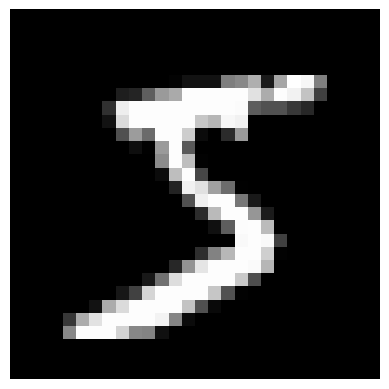

In [24]:
plt.imshow(x_train[0, :, :], cmap='gray')
plt.axis('off');

# PCA and Image Reconstruction

Recall that based on the PCA transformation, we can compute the reconstructed images with

$$ \hat{X} = (X W_L) W_L^T $$

Note that once we have computed the transformation matrix $W$, we essentially have a compression scheme to convert our images into a compressed format. From this perspective, using the first 5, 10, 30, and 100 principal components is equivalent to compressing the data at a rate of 156:1, 78:1, 26:1, and 8:1, respectively.  By contrast, JPEG image compression can obtain compression ratios of 23:1 with reasonable image quality, which is what we'd use if compression was our only interest here. 

In an earlier lab session, we have seen that PCA was effective for producing a 2D or 3D representation of the points using "interpretable" principal components (linear combinations of the original features - see the `iris` dataset), but not very effective for image compression: we needed at least 100 coordinates (an 8:1 compression) to have credible digits.

# Autoencoders

In this lab, we will devise a compression strategy using another method, autoencoders. **Autoencoders are neural networks which are trained to output their input** in such a way that they learn a reduced dimensional space of the input distribution. They are generally composed of two distinct "layers" (or two parts possibly composed of several layers). The first encodes the input space (encoder) and the second decodes the encoded space back to the original feature space (decoder). There are several main types of autoencoders:
1. __Undercomplete__ autoencoders work by constructing a network that has a hidden code layer that has fewer nodes than the input and output layers. After training, the smaller hidden layer will represent an encoding of the input onto a lower dimensional space.
2. __Regularized__ autoencoders use various regularization terms in the loss function during training to constrict the space of the output. For example, sparse autoencoders add a sparsity regularization term in the loss to force as many nodes as possible in the hidden layers to be zero.
3. __Variational__ autoencoders work slightly differently than the previous two. In this case, the autoencoder learns parameters that model the distribution of the input data in the encoder. The decoder is then used to reconstruct the output based on a random sample from this distribution. Their use is mainly directed towards data generation (*i.e.* generate credible faces).

In this exercise, we will consider **undercomplete** autoencoders.

## Undercomplete autoencoder: dense and *linear*

Recall that a dense linear neural network in the context of regression is similar to linear regression. Similarly, it is well known that an autoencoder with a linear decoder layer and a mean-squared-error loss function will learn the same feature space as PCA. Let's check this by creating a simple linear autoencoder.

**Exercise 1:** Create a simple linear autoencoder.

- Write a function which takes the `input_size` (denoted by $p$ previously) and the `code_size` (denoted by $L$ in lab 10 - not be confused with the depth of our `Network` in lab 6) and returns an autoencoder model using Keras.
  - The autoencoder should be comprised of
    - A dense **encoder** layer taking `input_size` inputs with `code_size` nodes and no activation function (implies an identity / linear activation function).
    - An identity / linear **decoder** layer with `input_size` nodes.
  - Compile the autoencoder using the Adam optimizer and MSE loss
  - In addition to the **autoencoder** (the encoder + decoder), return the **encoder** as well.
  
*Hint*: use another `Model` which just takes the input and returns the output of the encoder layer (the encoder).  
**Suggestion**: Use the [functional API documentation](https://keras.io/getting-started/functional-api-guide/).

In [25]:
def linear_autoencoder(input_size: int, code_size: int):
    """
    Instanciate and compiles an autoencoder, returns both the autoencoder and just the encoder
    (i.e. autoencoder except last layer)

    :param int input_size: shape of the input samples
    :param int code_size: dimension on which to project the original data
    :return: autoencoder, encoder
    """
    # autoencoder = ...
    # encoder = ...
    input_layer = Input(shape=(input_size,))
    
    encoder_layer = Dense(code_size, activation = None)(input_layer)
    
    decoder_layer = Dense(input_size)(encoder_layer)
    autoencoder = Model(inputs = input_layer, outputs = decoder_layer)
    autoencoder.compile(optimizer = 'adam', loss = 'mse')
    encoder = Model(inputs = input_layer, outputs = encoder_layer)

    return autoencoder, encoder

In [26]:
linear_ae, linear_encoder = linear_autoencoder(784, 2)
linear_ae.summary()

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 2)              │         1,570 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 784)            │         2,352 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,922 (15.32 KB)

 Trainable params: 3,922 (15.32 KB)

 Non-trainable params: 0 (0.00 B)

**Exercise 2:** Train the linear autoencoder.

- Using your function, create a linear autoencoder with the `input_size` corresponding to the MNIST dataset and a `code_size` of 2 (similar to what we did with PCA).
- Train the model using the MNIST data as input and output for at least 7 epochs.
- Plot the history of the loss versus the epoch number to make sure training is basically complete.

*Hint*: the history of the loss is silently returned by the call to [`fit`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit).

Epoch 1/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 551us/step - loss: 0.0645
Epoch 2/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 613us/step - loss: 0.0572
Epoch 3/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 530us/step - loss: 0.0566
Epoch 4/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 605us/step - loss: 0.0563
Epoch 5/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 605us/step - loss: 0.0562
Epoch 6/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 530us/step - loss: 0.0561
Epoch 7/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 508us/step - loss: 0.0560
Epoch 8/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 545us/step - loss: 0.0560
Epoch 9/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 476us/step - loss: 0.0561
Epoch 10/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 563us/step - loss: 0.0560
Epoch 11/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 536us/step - loss: 0.0560
Epoch 12/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 531us/step - loss: 0.0560
Epoch 13/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 504us/step - loss: 0.0560
Epoch 14/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 509us/step - loss: 0.0560
E

Text(0, 0.5, 'loss')

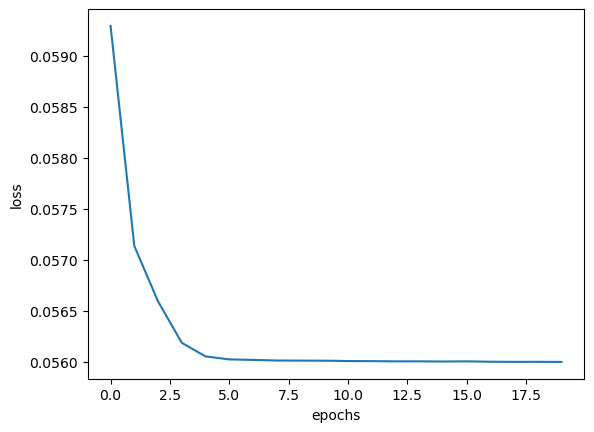

In [27]:
# linear_ae, linear_encoder = linear_autoencoder(input_size, code_size)
# linear_ae_history = ...
# plt.plot(history...)
# YOUR CODE HERE
input_size = 784
code_size = 2
linear_ae, linear_encoder = linear_autoencoder(input_size, code_size)
linear_ae_history = linear_ae.fit(x = x_train_reshaped, y = x_train_reshaped, epochs = 20)
plt.plot(linear_ae_history.history['loss']);
plt.xlabel('epochs')
plt.ylabel('loss')

**Exercise 3:** Use the trained encoder to project the MNIST data to 2 features.
- Plot the two components in a scatter plot similar to the one we produced in the PCA lab-tutorial.
- How does the scatter plot compare to the one we made with PCA? **Concise qualitative answer expected in the cell marked "YOUR ANSWER HERE"**.

Recall that this autoencoder should learn the same vector space as PCA, though it will not learn the exact same transformation (could be rotated, scaled, etc.). As in the PCA lab session, you might want to draw fewer points to be able to see something.

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 320us/step


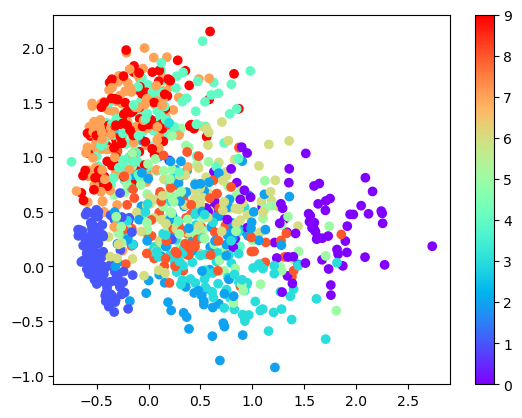

In [28]:
n_points = 1000
T = linear_encoder.predict(x_train_reshaped)
indices = np.random.randint(0, T.shape[0], n_points)
plt.scatter(T[indices, 0], T[indices, 1], c=y_train[indices], cmap='rainbow')
plt.colorbar();

YOUR ANSWER HERE

The scatter plot shows a similar structure to PCA but may be rotated or scaled differently. The digits are separate but with a significant cluster.

## Undercomplete autoencoder: *nonlinear*

We saw in the previous section that linear decoders and MSE loss produce the same result as PCA.  Therefore, we can see nonlinear encoders and decoders as a nonlinear generalization of PCA. By allowing nonlinear transformations, we should be able to increase the "expressiveness", or the quality of the representation / separation of our reduced variables.  

**Exercise 4:** Create a nonlinear autoencoder.

- Copy your linear autoencoder function into `nonlinear_autoencoder`.
- Add a dense hidden layer in between the input layer and encoder output layer. Give the hidden layer `input_size` / 4 nodes and use ReLU activations for both the encoder and this additional hidden layer.
- Add a dense hidden layer in between the encoder output and decoder output layers. Give the hidden layer `input_size` / 4 nodes and use ReLU activations for this additional hidden layer.
- Keep the same optimizer and loss.

In [29]:
def nonlinear_autoencoder(input_size, code_size: int):
    """
    Instanciate and compiles an autoencoder, returns both the autoencoder and just the encoder

    :param int or tuple input_size: shape of the input samples
    :param int code_size: dimension on which to project the original data
    :return: autoencoder, encoder
    """
    # YOUR CODE HERE
    input_layer = Input(shape=(input_size,))
    hidden_encoder = Dense(input_size // 4, activation='relu')(input_layer)
    encoded = Dense(code_size, activation='relu')(hidden_encoder)
    
    hidden_decoder = Dense(input_size // 4, activation='relu')(encoded)
    decoded = Dense(input_size, activation='sigmoid')(hidden_decoder)
    
    autoencoder = Model(input_layer, decoded)
    encoder = Model(input_layer, encoded)
    
    autoencoder.compile(optimizer='adam', loss='mse')    
    return autoencoder, encoder

In [30]:
nonlinear_ae, nonlinear_encoder = nonlinear_autoencoder(784, 2)
nonlinear_ae.summary()

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 196)            │       153,860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 2)              │           394 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 196)            │           588 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 784)            │       154,448 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 309,290 (1.18 MB)

 Trainable params: 309,290 (1.18 MB)

 Non-trainable params: 0 (0.00 B)

**Exercise 5:** Train the nonlinear autoencoder model.
- Create the nonlinear AE using 2 representation features as with the linear model.
- Train as before for at least 7 epochs and plot the loss history.

Epoch 1/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 682us/step - loss: 0.0659
Epoch 2/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 709us/step - loss: 0.0479
Epoch 3/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 699us/step - loss: 0.0458
Epoch 4/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 749us/step - loss: 0.0446
Epoch 5/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 594us/step - loss: 0.0438
Epoch 6/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 658us/step - loss: 0.0432
Epoch 7/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 909us/step - loss: 0.0426
Epoch 8/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 775us/step - loss: 0.0422
Epoch 9/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 781us/step - loss: 0.0420
Epoch 10/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 810us/step - loss: 0.0416
Epoch 11/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 526us/step - loss: 0.0411
Epoch 12/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 555us/step - loss: 0.0410
Epoch 13/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 619us/step - loss: 0.0407
Epoch 14/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 608us/step - loss: 0.0404
E

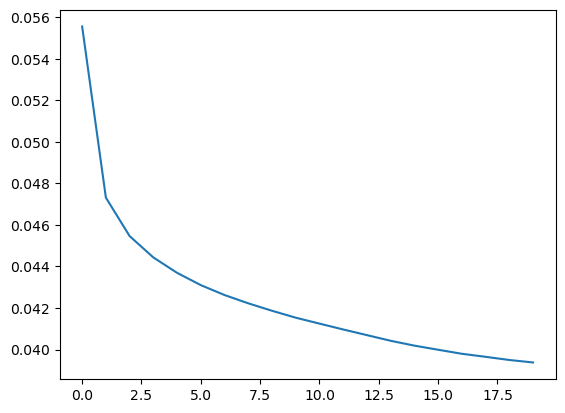

In [31]:
nonlinear_ae, nonlinear_encoder = nonlinear_autoencoder(input_size, code_size)
# nonlinear_ae_history = ...
# plt.plot(...)
# YOUR CODE HERE
nonlinear_ae_history = nonlinear_ae.fit(x = x_train_reshaped, y = x_train_reshaped, epochs = 20)
plt.plot(nonlinear_ae_history.history['loss'])
plt.show()

**Exercise 6:** Plot the scatter plot of the reduced variables, that is, the samples projected onto the 2-dimensional code space (similar to Exercise 3). **If you get a single ploint, it means the training was stuck in some bad local minimum, so re-run

- What can you say about grouping of points using the nonlinear model?  Does it seem to cluster the digits better than with the linear one? **Concise qualitative answer expected in cell marked "YOUR ANSWER HERE"**.

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 290us/step


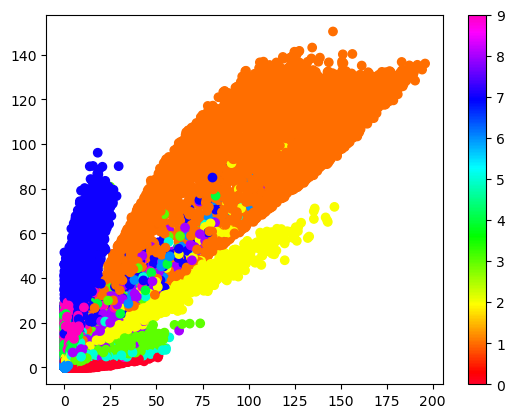

In [32]:
# ... nonlinear_encoder...(...)
# plt.scatter(...)  # <- TO UNCOMMENT AND COMPLETE
# YOUR CODE HERE
M = nonlinear_encoder.predict(x_train_reshaped)  
plt.scatter(M[:,0], M[:,1], cmap='gist_rainbow', c = y_train)
plt.colorbar();

YOUR ANSWER HERE

The clustered digits are also overlapping but it seems to better cluster with the nonlinear model.

**Exercise 7:** Calculate the number of parameters of the encoders defined in Exercises 4 and store it in the variable `nonlinear_encoder_number_of_parameters`.

In [33]:
nonlinear_encoder_number_of_parameters = nonlinear_encoder.count_params()

# YOUR CODE HERE
nonlinear_encoder_number_of_parameters

154254

## Reconstruct Images

**Exercise 8:** Use the autoencoders to produce reconstructed images from the MNIST data as we did with PCA.
- Train linear, nonlinear and cnn encoder autoencoders on the MNIST data using a `code_size` of 15.
- Compare the loss histories of the training for both models on the same plot. What does this tell you about the expressiveness, i.e. the quality of the reconstruction of the two models?

Epoch 1/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 644us/step - loss: 0.0704
Epoch 2/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 801us/step - loss: 0.0508
Epoch 3/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 740us/step - loss: 0.0481
Epoch 4/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 617us/step - loss: 0.0465
Epoch 5/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 884us/step - loss: 0.0455
Epoch 6/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 708us/step - loss: 0.0445
Epoch 7/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 729us/step - loss: 0.0439
Epoch 8/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 675us/step - loss: 0.0433
Epoch 9/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 783us/step - loss: 0.0430
Epoch 10/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 629us/step - loss: 0.0425
Epoch 11/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 655us/step - loss: 0.0422
Epoch 12/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 613us/step - loss: 0.0421
Epoch 13/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 626us/step - loss: 0.0417
Epoch 14/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 732us/step - loss: 0.0414
E

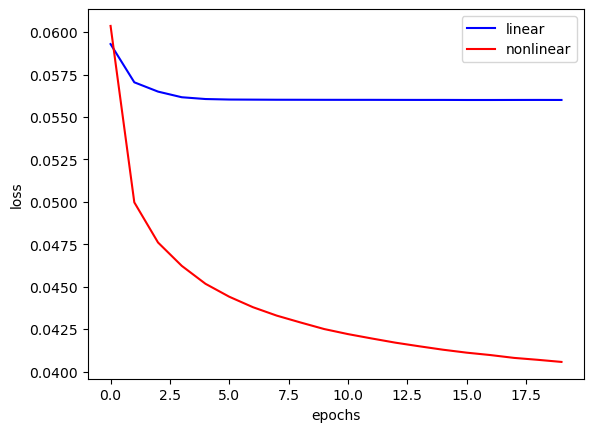

In [34]:
# Train autoencoder models, get history of losses
# Plot the losses

# YOUR CODE HERE
nonlinear_ae, nonlinear_encoder = nonlinear_autoencoder(input_size, code_size)
nonlinear_ae_history = nonlinear_ae.fit(x = x_train_reshaped, y = x_train_reshaped, epochs = 20)

linear_ae, linear_encoder = linear_autoencoder(input_size, code_size)
linear_ae_history = linear_ae.fit(x = x_train_reshaped, y = x_train_reshaped, epochs = 20)

plt.plot(linear_ae_history.history['loss'], color = "b")
plt.plot(nonlinear_ae_history.history['loss'], color = "r")
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['linear', 'nonlinear']);
plt.show()


YOUR ANSWER HERE

The nonlinear autoencoder achieves lower reconstruction loss than the linear version, demonstrating its greater expressive power for modeling complex image data. This shows nonlinear transformations can capture more intricate patterns in MNIST digits than the PCA-like linear approach.

Let's see what this will yield in terms of reconstruction quality / compression capability.

**Exercise 9:** Use the two AEs to produce reconstructed images (as you did in an earlier lab session with PCA).

- Generate a grid of images
  - The first row should contain the first 5 images in the MNIST set as before.
  - The second row should contain their reconstruction using the linear model.
  - The third row should contain the reconstructions using the nonlinear model.
  - The fourth row should contain the reconstructions using the nonlinear model with a CNN encoder.
- How well do each of the models reproduce the images? 
- How do they compare to the PCA reconstructions?

Recall from Exercise 8 that we used a `code_size` of 15, achieving a 784:15 $\approx$ 52:1 compression! 

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 360us/step
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 406us/step


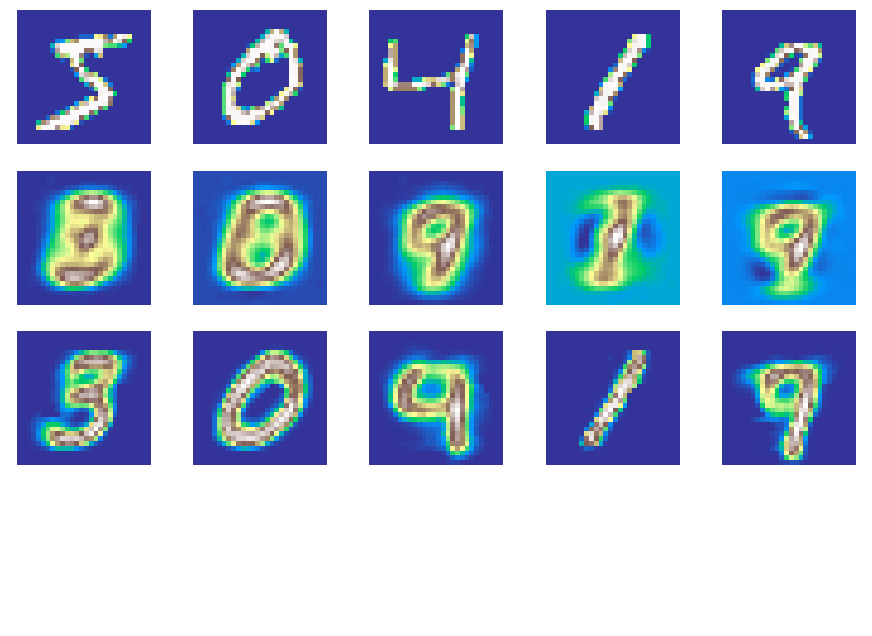

In [35]:
# YOUR CODE HERE
linear = linear_ae.predict(x_train_reshaped)
nonlinear = nonlinear_ae.predict(x_train_reshaped)

f, axes = plt.subplots(4, 5, figsize=(11, 8)) 
for i in range(5):
    axes[0, i].imshow(x_train[i], cmap='terrain')  
    axes[1, i].imshow(linear[i, :].reshape(28, 28), cmap='terrain')  
    axes[2, i].imshow(nonlinear[i, :].reshape(28, 28), cmap='terrain')  
    for j in range(4):
        axes[j, i].axis('off') 

plt.show()

YOUR ANSWER HERE

The second row is the reconstruction of pictures using the linear model and the third row is using the nonlinear model. We clearly see that the images reconstructes with the non linear model is better than the linear one, it reconstructs the pictures with les noise. Especially with the linear model we see that it didn't picture the number 4 correctly.

## Beyond this lab

Having understood the theory and implementation of a linear and non-linear auto-encoder, there are several things to think about futher: 

* Performance vs image compression algorithms: See the wikipedia entry for [JPEG](https://en.wikipedia.org/wiki/JPEG#Encoding) ([discrete cosine basis](https://en.wikipedia.org/wiki/Discrete_cosine_transform)) and [JPEG2000](https://en.wikipedia.org/wiki/JPEG_2000) ([wavelet transform basis](https://en.wikipedia.org/wiki/Wavelet_transform)).

* Better networks and better performance: We were working with images, so it makes sense to consider convolutional neural networks. Consider complexifying your non-linear auto-encoder, for example: use a *CNN*, more layers, try different activation functions, `Dropout`, batch normalization in 2D. Then rerun Exercices 7: were you able to achieve even better image reconstruction quality?

* Generation: How to generate new images? Reconstruction is not the same as generation (even if reconstruction is an important part of generation). Reconstruction is deterministic, $\mathbf{x} = g(\mathbf{z})$  (if $g$ to represent the decoder), but which novel $\mathbf{z}$ to choose? Generation should be something like $\mathbf{x} \sim p(\mathbf{x})$. Consider using Gaussian mixture models to provide $\mathbf{z} \sim p(\mathbf{z})$, and then decoding hidden-representation (code) $\mathbf{z}$ to get novel image $\mathbf{x}$.

## Tiny Language Models or: Sequence Modeling with Auto-regressive Machine Learning Models

Human languages are complex, because the world we live in is complex. So, in machine learning, language models have to be large, to represent those complexities. 

In this lab we consider an ultra simplistic simulated 'world', and a 'language' to go with it; so simple that we don't have to worry about 'scaling up', and we can instead take the time to consider some of the underlying principles. 

In the following we simulate a 'world', as a hidden markov model (exemplified here for $t=4$):

![HMM](https://www.lix.polytechnique.fr/~jread/tmp/hmm.png)

We specify transition probabilities as $P_\theta(y_{t+1} \mid y)$ and observations as $x = \phi(y)$, i.e., the observation function is deterministic in this example, but in general the observation can be stochastic for a given state.

Just like in the real world, we only have access to 'observations' of the world, not the 'ground truth' model (hence the 'hidden' aspect). We might consider an observation `seq[t]` as a word describing an observation at time `t`. Therefore a sequence of observations `x` is a 'sentence' where each 'word' is indexed by a number (just like in real language models). Some imagination is required to think of this as a language, but not too much. 

Notice how the observations 'inherit' the randomness of the state transitions of the world, such that $x_t$ can be considered as a random variable. Each sequence (an 'instance' of sorts) may thus be different. 

In [36]:
# Define a hidden markov model for our micro world model (states are hidden, observations are not)

phi = {
        0 : [0],
        1 : [4],
        2 : [2],
        3 : [3],
        4 : [3],
        5 : [2],
        6 : [1],
        7 : [4],
        8 : [5],
}

theta = {
        0 : [0,1],
        1 : [2],
        2 : [1,3],
        3 : [4,6],
        4 : [2,5],
        5 : [5,6],
        6 : [7],
        7 : [8],
}

def gen_seq(y=0):
    # only record observations 
    x = phi[y][0]
    seq = [x]
    while y != 8: 
        # not in terminal state, generate (and record) observation, and proceed to next state 
        y = np.random.choice(theta[y])
        x = phi[y][0]
        seq.append(x)
    return seq

In [37]:
# Generate a sequence
print(gen_seq(0))

[0, 0, 0, 0, 0, 0, 4, 2, 3, 3, 2, 1, 4, 5]


In [38]:
# Build a dataset of sequences 
D = []
n = 100
for i in range(n):
    seq_i = gen_seq()
    D.append(seq_i)

### Building a generative model

Your task is to learn to (actually: use machine learning to create a model that can) 'speak' this language, in a way which has some meaning in the fake world we created above. 

**TASK:** . Use *any* method you like to generate sequences that 'make sense' (can actually occur, outside of hallucinations). Store these sequences. 

**Constraints:**
1. Each generated sequence should be 'realistic' with respect to the 'world model' in question (it should not be possible to detect that it is fake)
2. You should have generated some sequences which are novel, i.e., have never been seen in the training data
3. Use (only) `D` as training data
4. Generate `10` sequences, store them in `D_fake`.       

**HINT**: Several possibilities were discussed in the lecture, including using 'off the shelf' tools. So, you can use existing modules (as `nn.TransformerDecoder`), or leverage those is `sklearn`, or create your own from scratch. The emphasis is on the modelling of the problem, not the predictive performance (it is not required to choose a state of the art architecture). Also, note that a sequence always starts with `0` and ends with `5`.

In [43]:
import torch
import torch.nn as nn
import sklearn
import sklearn.tree

D_fake = []

# YOUR CODE HERE
import numpy as np
from collections import defaultdict

transition_counts = defaultdict(lambda: defaultdict(int))
for seq in D:
    for i in range(len(seq)-1):
        current = seq[i]
        next_val = seq[i+1]
        transition_counts[current][next_val] += 1

transition_probs = defaultdict(dict)
for current, next_counts in transition_counts.items():
    total = sum(next_counts.values())
    for next_val, count in next_counts.items():
        transition_probs[current][next_val] = count / total

def generate_sequence():
    seq = [0]
    current = 0
    while current != 5:
        next_vals = list(transition_probs[current].keys())
        probs = list(transition_probs[current].values())
        if not next_vals:
            break
        next_val = np.random.choice(next_vals, p=probs)
        seq.append(next_val)
        current = next_val
    return seq

D_fake = []
for _ in range(10):
    new_seq = generate_sequence()
    D_fake.append(new_seq)

for i, seq in enumerate(D_fake[:10]):
    print(f"{seq}")

[0, 0, 0, 4, 2, 3, 1, 4, 5]
[0, 0, 4, 2, 3, 3, 2, 1, 4, 5]
[0, 0, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 2, 4, 2, 4, 2, 4, 2, 4, 5]
[0, 0, 4, 2, 3, 1, 4, 2, 3, 1, 4, 2, 3, 3, 1, 4, 2, 2, 4, 5]
[0, 0, 4, 2, 1, 4, 2, 1, 4, 2, 3, 2, 4, 2, 4, 5]
[0, 4, 5]
[0, 4, 5]
[0, 4, 2, 3, 1, 4, 5]
[0, 4, 5]
[0, 0, 0, 4, 2, 4, 2, 1, 4, 2, 4, 2, 3, 1, 4, 2, 4, 5]


### Afterthoughts

Like real natural language, there are infinite possible sentences (sequences). Thus, you should be able to appreciate the difficulties in evaluating an LLM, and the need for scalable high-capacity architectures for LLMs. However, also like natural language, that doesn't mean that any combination of words is a valid sentence. Some sequences are possible (or: 'gramatically correct') yet do not reflect what actually happened. In LLMs we call that hallucination. 

Sequence modelling can be tackled by machine learning in many different forms. Auto-regressive models are also self-supervised like auto-encoders, except they don't predict the same tokens as input, but the *next* token in the sequence. If you chose a neural architecture above, you would be able to reuse it for other tasks on the same sequences, such as classification. 

You should recognise that you have essentially trained and tested a language/sequence model. Neural architectures were not required for such a simple concept, and it you should have found it rapid to train from scratch. This is one of the qualitative changes of working with a real language and scaling up.